# Introduction to NLP fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences of text or speech).

Another common term for NLP problem is sequence to sequence problems (seq2seq).

## Check for GPU

In [1]:
!nvidia-smi
!nvidia-smi -L

Tue Jul 12 07:01:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.59       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   49C    P8    18W /  N/A |    955MiB /  6144MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get helper functions

In [2]:
import os
if not os.path.exists("helper_functions.py"):
    !python -m wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster).

See the original source: https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners/notebook

In [3]:
if not os.path.exists("nlp_getting_started.zip"):
    !python -m wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
unzip_data("C:/Selbststudium/Udemy/Udemy_TensorFlow_Certificate/nlp_getting_started.zip")

## Visualizing a text dataset

To visualize our text samples, we first have to read them in , one way to do so would be to use Python: https://realpython.com/read-write-files-python/ 

But i prefer to get visual straight away.

So another way to do this is to use pandes...

In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df["text"][1], train_df["target"][1]

('Forest fire near La Ronge Sask. Canada', 1)

In [6]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


# What does the test dataframe look like?
test_df.head()

In [7]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [9]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # Create random indexes not higher than the total number
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
    print(f"Text: {text}\n")

Target: 0 (not real disaster)
Text: @MistressPip I'm amazed you have not been inundated mistress.

Target: 0 (not real disaster)
Text: [GPV Wind] As of 06JST 6AUG: WNW 06JST 6AUG / E 12JST 6AUG / S 18JST 6AUG. http://t.co/l6jBjAj8dm

Target: 1 (real disaster)
Text: APC Chieftain Tasks Dickson On N15b Floods Donation To Bayelsa http://t.co/LqGOe7psXp

Target: 1 (real disaster)
Text: Saving the City in Old Town: The Proposed Demolition of 159 West Burton http://t.co/FJddx43Ewj @MessnerMatthew for @newcity

Target: 0 (not real disaster)
Text: POTUS appoints Brig. Gen. Richard G. Kaiser as member of the Mississippi River Commission. Learn more about the MRC: http://t.co/vdUKcV7YJy



### Split data into training and validation sets

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Use train_test_split to split training data into training and validation sets 
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_df_shuffled["text"].to_numpy(),
    train_df_shuffled["target"].to_numpy(),
    test_size=0.1,
    random_state=42)

In [12]:
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [13]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Cnverting text into numbers

When dealing with a text problem, one of the first thing you'll have to do before you can build a model is to convert your text to numbers. 

There are a few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word or a character)
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [14]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [15]:
train_sentences[0].split(), len(train_sentences[0].split())

(['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet'], 7)

In [16]:
# Find the average number of tokes (words) in the training tweets
max_length = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
max_length

15

In [17]:
max_vocab_length = 10000

In [18]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    standardize="lower_and_strip_punctuation", # Default
    split="whitespace", # Default
    ngrams=None, # Default
    output_mode="int",
    output_sequence_length=max_length,
    pad_to_max_tokens=True) # Default

In [19]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [20]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int64)>

In [21]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\n\
    Vectorized version:")
text_vectorizer([random_sentence])

Original text:
Top link: Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/o8XvTLP4mF
    Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 212, 1074,  878,   50,  226,  595,  512,   66,  780,  123,  395,
         918,  793,   53,  433]], dtype=int64)>

In [22]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
len(words_in_vocab), top_5_words, bottom_5_words

(10000,
 ['', '[UNK]', 'the', 'a', 'in'],
 ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1'])

### Creating an Embedding using an EmbeddingLayer

To make our embedding, we're going to use TensorFlow's EmbeddingLayer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer: 
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each tolen gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer 

In [23]:
from tensorflow.keras import layers

embedding = layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=128,
    input_length=max_length)
embedding

In [24]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
    \nEmbedded version: ")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Paul Craig Roberts ÛÒ Vladimir Putin Issues Major Warning But Is It Too Late To Escape A http://t.co/NVfKzv5FEx #brics #roberts #russia    
Embedded version: 


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04891973,  0.04736659, -0.03571372, ...,  0.02649527,
         -0.02896649,  0.02546373],
        [ 0.01254879, -0.00744461, -0.02050283, ...,  0.01598382,
          0.01984534,  0.02964808],
        [ 0.0107003 , -0.04386288, -0.0295881 , ...,  0.0267735 ,
         -0.02421486,  0.04811308],
        ...,
        [ 0.00535109, -0.01134799,  0.02069268, ..., -0.03748838,
          0.00892508,  0.03023869],
        [-0.00036003, -0.02903252, -0.03873315, ...,  0.04375435,
         -0.0243019 ,  0.03859427],
        [-0.04920788,  0.01116934, -0.03242011, ..., -0.03320735,
         -0.00565697,  0.00040314]]], dtype=float32)>

In [25]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 4.8919726e-02,  4.7366593e-02, -3.5713721e-02, -3.8636971e-02,
         1.0832977e-02,  4.4510849e-03,  4.7425199e-02,  2.0172130e-02,
        -1.2726046e-02, -4.4271328e-02, -3.0293489e-02,  1.1286199e-02,
        -6.2276833e-03, -1.3142936e-03,  4.8652019e-02, -3.2233894e-02,
         4.6658549e-02,  1.4312986e-02, -3.6838733e-02,  1.7869603e-02,
        -2.1557689e-02, -6.5167546e-03,  3.4328703e-02,  2.1289479e-02,
         9.6921809e-03, -2.9338038e-02, -1.0357998e-02, -4.3938436e-02,
        -1.5208472e-02,  1.9760240e-02, -4.0905632e-02, -8.8608153e-03,
        -4.2070746e-03, -3.8174856e-02,  3.0935142e-02,  9.4338544e-03,
         4.3139346e-03,  1.5246283e-02,  4.3030288e-02, -1.6224276e-02,
         3.6810044e-02, -2.5422847e-02,  4.8510376e-02, -7.5422227e-05,
        -1.1930991e-02, -1.1389565e-02,  2.7467553e-02, -2.4855435e-02,
        -3.4005262e-02,  2.3005534e-02,  2.3369107e-02,  1.5406821e-02,
         1.4387

## Modelling a text dataset (running a series of experiments)

Now we've got a way to turn our text sequences into numbers, it's time  to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline), from sklearn ML map: 
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM (RNN)
* Model 3: GRU (RNN) 
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going to approach all of these?

Use the standard steps in modelling with tensorflow:
* Create a model
* Build the model
* Fit the model
* Evaluate the model

### Model 0: Getting a baseline

As with all machine learning modelling experiments it's important to create a baseline model so you've got a benchmark for future experiments to build uopn.

To create our baseline, we'll use Sklearn's Mulinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

> 🔑 **Note:** It's common to use non DL-algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([ # Pipeline is similar to tensorflow's sequential
    ("tfidf", TfidfVectorizer()), # name of the step is "tfidf"; convert words to numbers using tfidf
    ("clf", MultinomialNB()), # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [28]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=int64)

In [29]:
train_labels

array([0, 0, 1, ..., 1, 1, 0], dtype=int64)

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics every time, however this will be cumbersome and could easily be fixed with a function.

Let's create one to compare our model's predictions with the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score

For a deep overview of many different methods, see the Sklearn documentation.

In [30]:
# Function to evaluate accuracy, precision, reall and f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binare classification model.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1-score using "weighted" average
    model_precision, model_recall, model_f1, _, = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {
        "accuracy": model_accuracy, 
        "precision": model_precision,
        "recall": model_recall, 
        "f1-score": model_f1}
    return model_results

In [31]:
# Get baseline results
baseline_results = calculate_results(
    y_true=val_labels,
    y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1-score': 0.7862189758049549}

### Model 1: A simple dense model

In [32]:
# Create a tensorboard callback (Need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save tensorboard logs
SAVE_DIR = "model_logs"

In [33]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Compile model
model_1.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"])

In [35]:
# Fit the model
model_1_history = model_1.fit(
    x=train_sentences,
    y=train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(
        dir_name=SAVE_DIR,
        experiment_name="model_1_dense"
    )]
)

Saving TensorBoard log files to: model_logs/model_1_dense/20220712-070132
Epoch 1/5
215/215 [==============================] - 3s 6ms/step - loss: 0.6102 - accuracy: 0.6929 - val_loss: 0.5344 - val_accuracy: 0.7598
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.4418 - accuracy: 0.8156 - val_loss: 0.4709 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3471 - accuracy: 0.8626 - val_loss: 0.4603 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2841 - accuracy: 0.8911 - val_loss: 0.4648 - val_accuracy: 0.7913
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2369 - accuracy: 0.9121 - val_loss: 0.4800 - val_accuracy: 0.7887


In [36]:
baseline_results,

({'accuracy': 79.26509186351706,
  'precision': 0.8111390004213173,
  'recall': 0.7926509186351706,
  'f1-score': 0.7862189758049549},)

In [37]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4800 - accuracy: 0.7887


[0.4800204038619995, 0.7887139320373535]

In [38]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs

array([[3.26800764e-01],
       [7.53424823e-01],
       [9.97852206e-01],
       [8.49002600e-02],
       [1.01164453e-01],
       [9.30915058e-01],
       [9.22577500e-01],
       [9.93345499e-01],
       [9.67820883e-01],
       [2.11431876e-01],
       [1.13343917e-01],
       [6.57970846e-01],
       [4.44574840e-02],
       [2.09898397e-01],
       [5.04573481e-03],
       [1.13284126e-01],
       [2.60618776e-02],
       [8.25275853e-02],
       [1.87564194e-01],
       [4.99211848e-01],
       [9.04086888e-01],
       [4.20053005e-02],
       [3.97532195e-01],
       [7.81666562e-02],
       [9.61529434e-01],
       [9.98942435e-01],
       [2.86790766e-02],
       [6.27055243e-02],
       [2.45401524e-02],
       [2.15850443e-01],
       [4.89037335e-01],
       [2.30490252e-01],
       [4.77458566e-01],
       [1.71117097e-01],
       [4.66904610e-01],
       [5.78024574e-02],
       [9.93622720e-01],
       [1.25244826e-01],
       [3.46464291e-02],
       [9.98710155e-01],


In [39]:
# Look at a single prediction
model_1_pred_probs[0]

array([0.32680076], dtype=float32)

In [40]:
# Look at the first 10
model_1_pred_probs[:10]

array([[0.32680076],
       [0.7534248 ],
       [0.9978522 ],
       [0.08490026],
       [0.10116445],
       [0.93091506],
       [0.9225775 ],
       [0.9933455 ],
       [0.9678209 ],
       [0.21143188]], dtype=float32)

In [41]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [42]:
# Calculate our model_1 results
model_1_results = calculate_results(
    y_true=val_labels,
    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.87139107611549,
 'precision': 0.7953441303708004,
 'recall': 0.7887139107611548,
 'f1-score': 0.7852145092095362}

In [43]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1-score': 0.7862189758049549}

In [44]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing learned embeddings


In [45]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [46]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Get the weight matrix of embedding layer
# (these are the numerical representations of each token in our training data, which have been learned for 5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights)
print(embed_weights.shape) # same size as vocab size and embedding_dim (output_dim of our embedding layer)

[[-0.04966221 -0.02226266 -0.01261823 ... -0.06546193  0.02754869
   0.04124602]
 [ 0.00408755 -0.00347629 -0.02836252 ...  0.00737716  0.02803759
   0.03802251]
 [-0.04759025  0.00741608 -0.03622359 ... -0.0056222   0.00844918
  -0.0373669 ]
 ...
 [ 0.01361053 -0.02107885  0.02404416 ... -0.03644736 -0.03101446
  -0.04373557]
 [-0.07225454  0.05843375 -0.0312656  ... -0.05943295  0.07886267
   0.01836548]
 [-0.07404425  0.07273775 -0.06225554 ... -0.02402026  0.06315358
   0.05549434]]
(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handy tool called projector: http://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embeddings themselves: https://www.tensorflow.org/text/guide/word_embeddings

In [48]:
# Create embedding files (we got this from TensorFlow's word embeddings documentation)
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()


Downloading the files above we can visualize them using http://projector.tensorflow.org/ and clicking the "load" button on  the left hand side.

> 📖 **Ressource:** If you'd like to know more about embeddings, I'd encourage you to check out:
* Jay Alammar's visualized word2vec post: https://jalammar.github.io/illustrated-word2vec/
* TensorFlow's Word Embeddings guide: https://www.tensorflow.org/tutorials/text/word_embeddings

## Recurrent Neural Networks (RNNs)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

> 📖 **Ressources:** If you want an overview of the internals of a recurrent neural network, see the following:
 - MIT's sequence modell lecture: https://youtu.be/qjrad0V0uJE
 - Chris Olag's intro to LSTMs: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
 - Andrej Kaparthy's the unreasonable effectiveness of recurrent neural networks: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

### Model 2: LSTM
LSTM  = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:
```Input(text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)```

In [49]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1, ), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [50]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,333,633
Trainable params: 1,333,633
Non-trainable params: 0
____________________________________________

In [51]:
# Compile the nmodel
model_2.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [52]:
# Fit
histor_model_2 = model_2.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(
        SAVE_DIR,
        "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20220712-070142
Epoch 1/5
215/215 [==============================] - 5s 11ms/step - loss: 0.2278 - accuracy: 0.9202 - val_loss: 0.6266 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1550 - accuracy: 0.9418 - val_loss: 0.6030 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1265 - accuracy: 0.9530 - val_loss: 0.7110 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1046 - accuracy: 0.9606 - val_loss: 0.7325 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0845 - accuracy: 0.9669 - val_loss: 1.0062 - val_accuracy: 0.7769


In [53]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[2.6292415e-02],
       [9.2476857e-01],
       [9.9998355e-01],
       [1.4503796e-01],
       [1.2629501e-04],
       [9.9873036e-01],
       [9.6425557e-01],
       [9.9999118e-01],
       [9.9997711e-01],
       [5.4786944e-01]], dtype=float32)

In [54]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [55]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0], dtype=int64)

In [56]:
# Calculate model 2 results
model_2_results = calculate_results(
    y_true=val_labels,
    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.69028871391076,
 'precision': 0.7781874595396938,
 'recall': 0.7769028871391076,
 'f1-score': 0.7751243211017478}

In [57]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1-score': 0.7862189758049549}

### Model 3: GRU

Another popular and effective component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

> 📖 **Ressource:** 
 - https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be
 - https://en.wikipedia.org/wiki/Gated_recurrent_unit

In [58]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.GRU(64, return_sequences=True)(x) # if you wand to stack recurrent layers --> return_sequences = True
# x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GRU(64)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [59]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,321,473
Trainable params: 1,321,473
Non-trainable params: 0
_____________________________________________

In [60]:
# Compile the model
model_3.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"])

In [61]:
# Fit 
model_3_history = model_3.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(
        SAVE_DIR,
        "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20220712-070156
Epoch 1/5
215/215 [==============================] - 4s 11ms/step - loss: 0.1510 - accuracy: 0.9422 - val_loss: 0.7732 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0824 - accuracy: 0.9689 - val_loss: 0.8492 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0676 - accuracy: 0.9729 - val_loss: 1.1246 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0568 - accuracy: 0.9737 - val_loss: 1.3070 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0535 - accuracy: 0.9762 - val_loss: 1.1800 - val_accuracy: 0.7598


In [62]:
# Make predictions
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[1.9374516e-02],
       [7.1505970e-01],
       [9.9988544e-01],
       [1.7611142e-01],
       [3.9015518e-05],
       [9.9943978e-01],
       [8.8901144e-01],
       [9.9998307e-01],
       [9.9996722e-01],
       [8.7685621e-01]], dtype=float32)

In [63]:
# Convert pred_probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [64]:
# Calculate model 3 results
model_3_results = calculate_results(
    y_true=val_labels,
    y_pred=model_3_preds)
model_3_results

{'accuracy': 75.98425196850394,
 'precision': 0.7604578907479682,
 'recall': 0.7598425196850394,
 'f1-score': 0.758116023760764}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence), however a bidirectional RNN goes from right to left as well as left to right.

> 📖 **Ressources:** 
 - https://easy-tensorflow.com/tf-tutorials/recurrent-neural-networks/bidirectional-rnn-for-classification

In [65]:
# Build a bidirectional RNN (BRNN)
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_BRNN")

In [66]:
model_4.summary()

Model: "model_4_BRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


In [67]:
model_4.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_4.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(
        SAVE_DIR,
        "model_4_BRNN")])

Saving TensorBoard log files to: model_logs/model_4_BRNN/20220712-070207
Epoch 1/5
215/215 [==============================] - 6s 17ms/step - loss: 0.1046 - accuracy: 0.9711 - val_loss: 0.8441 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0543 - accuracy: 0.9777 - val_loss: 1.1930 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0483 - accuracy: 0.9772 - val_loss: 1.4213 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0425 - accuracy: 0.9803 - val_loss: 1.2747 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0428 - accuracy: 0.9791 - val_loss: 1.3473 - val_accuracy: 0.7743


In [68]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[3.1677885e-03],
       [8.3491397e-01],
       [9.9996483e-01],
       [1.4854281e-01],
       [3.2716867e-05],
       [9.9977571e-01],
       [9.5332438e-01],
       [9.9998736e-01],
       [9.9996579e-01],
       [9.9033737e-01]], dtype=float32)

In [69]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [70]:
model_4_results = calculate_results(
    y_true=val_labels,
    y_pred=model_4_preds
)
model_4_results

{'accuracy': 77.42782152230971,
 'precision': 0.7757380419380466,
 'recall': 0.7742782152230971,
 'f1-score': 0.7723566516531356}

## Convolutional Neural Networks for Text (and other types of sequences)

We've used CNNs for images but images are typically 2D (height x width)... however our textdata is 1D.

Previously we've used Conv2D for our image data but now we're going to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):
```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probabilities)
```

### Model 5: Conv1D

For different explanations of parameters see:
* https://poloclub.github.io/cnn-explainer/ (this is for 2D but can relate to 1D data)
* Difference between same and valid padding: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t


In [71]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["This a test sentence"])) # turn target sequence into an embedding
conv_1d = layers.Conv1D(
    filters=32,
    kernel_size=5,
    activation="relu",
    padding="same"
)
conv_1d_output = conv_1d(embedding_test) #6 pass test embedding through our Conv1D layer
max_pool = layers.GlobalMaxPooling1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature" or "get the feature with the highest value"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 32]), TensorShape([1, 32]))

In [72]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.00260698,  0.00629941, -0.06542943, ..., -0.04972068,
          0.04573457,  0.01191765],
        [-0.02259542,  0.00359447, -0.02439448, ..., -0.07503128,
          0.00994909,  0.03176597],
        [-0.01003832,  0.00419868, -0.01823566, ..., -0.00316939,
          0.00969158,  0.02466266],
        ...,
        [-0.01512512, -0.01838983, -0.00521517, ..., -0.03979459,
          0.01658619,  0.03571813],
        [-0.01512512, -0.01838983, -0.00521517, ..., -0.03979459,
          0.01658619,  0.03571813],
        [-0.01512512, -0.01838983, -0.00521517, ..., -0.03979459,
          0.01658619,  0.03571813]]], dtype=float32)>

In [73]:
conv_1d_output

<tf.Tensor: shape=(1, 15, 32), dtype=float32, numpy=
array([[[8.63533653e-03, 0.00000000e+00, 7.91355781e-03, 0.00000000e+00,
         3.53766605e-02, 0.00000000e+00, 5.26539236e-02, 4.17806022e-02,
         0.00000000e+00, 0.00000000e+00, 6.16391972e-02, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 1.91591997e-02, 0.00000000e+00,
         4.34289593e-03, 3.17498818e-02, 6.53036684e-03, 4.19761334e-03,
         0.00000000e+00, 0.00000000e+00, 4.84016985e-02, 0.00000000e+00,
         0.00000000e+00, 7.29408339e-02, 0.00000000e+00, 2.87921187e-02,
         6.04796223e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         2.79488806e-02, 6.00867160e-02, 0.00000000e+00, 4.91102189e-02,
         0.00000000e+00, 2.18112785e-02, 7.40704453e-03, 0.00000000e+00,
         0.00000000e+00, 4.33073714e-02, 2.15624403e-02, 3.74829657e-02,
         3.95212248e-02, 4.07445729e-02, 9.76344422e-02, 2.21728850e-0

In [74]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.01167172, 0.04381491, 0.01139366, 0.01507255, 0.03537666,
        0.06008672, 0.05265392, 0.04911022, 0.05522873, 0.02181128,
        0.0616392 , 0.00680069, 0.04475275, 0.04330737, 0.02156244,
        0.04315428, 0.03952122, 0.04074457, 0.09763444, 0.02217289,
        0.02708424, 0.05554856, 0.0484017 , 0.        , 0.08929533,
        0.07294083, 0.        , 0.03651625, 0.09046873, 0.        ,
        0.0263394 , 0.04581526]], dtype=float32)>

In [75]:
# Create 1-d convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(
    filters=64, 
    kernel_size=5, # each filter is looking at 5 words at a time
    strides=1,
    activation="relu",
    padding="valid",
)(x)
x = layers.GlobalMaxPool1D()(x)
# x =layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")


In [76]:
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 64)            41024     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 1,321,089
Trainable params: 1,321,089
Non-trainable params: 0
__________________________________________

In [77]:
model_5.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [78]:
model_5.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(
        SAVE_DIR,
        "model_5_Conv1D"
    )]
)

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20220712-070225
Epoch 1/5
215/215 [==============================] - 3s 10ms/step - loss: 0.1157 - accuracy: 0.9607 - val_loss: 0.9073 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0729 - accuracy: 0.9742 - val_loss: 1.0694 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0611 - accuracy: 0.9750 - val_loss: 1.1713 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0538 - accuracy: 0.9785 - val_loss: 1.2082 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0506 - accuracy: 0.9783 - val_loss: 1.2428 - val_accuracy: 0.7625


In [79]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[3.9553714e-01],
       [9.0814704e-01],
       [9.9992967e-01],
       [5.3250343e-02],
       [8.8510546e-07],
       [9.9697292e-01],
       [9.8047560e-01],
       [9.9994326e-01],
       [9.9999976e-01],
       [8.1423944e-01]], dtype=float32)

In [80]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [81]:
model_5_results = calculate_results(
    y_true=val_labels,
    y_pred=model_5_preds
)
model_5_results

{'accuracy': 76.24671916010499,
 'precision': 0.7629611993882945,
 'recall': 0.7624671916010499,
 'f1-score': 0.7608791530897157}

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've build a few of our own model, let's try and use transfer leraning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder.

In [82]:
sample_sentence

"There's a flood in my street"

In [83]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01154495  0.02487101  0.02879629 -0.01272263  0.0396995   0.08829076
  0.02682647  0.05582222 -0.01078761 -0.00596656  0.00640639 -0.01816132
  0.0002885   0.09106605  0.05874373 -0.03175148  0.01510154 -0.05164852
  0.00994341 -0.06867752 -0.04210395  0.02675389  0.03008907  0.00320448
 -0.00336864 -0.0479053   0.02267517 -0.00984555 -0.04066692 -0.01285528
 -0.04665243  0.05630673 -0.03952145  0.00521895  0.02495947 -0.07011834
  0.02873132  0.04945794 -0.00634556 -0.08959357  0.02807156 -0.00809173
 -0.01363955  0.05998397 -0.10361549 -0.05192674  0.0023246  -0.0232653
 -0.03752431  0.03332979], shape=(50,), dtype=float32)


In [84]:
# Create a Keras Layer using the USW pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[],
    dtype=tf.string,
    trainable=False,
    name="USE"
)

In [85]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer"),
], name="model_6_USE")

In [86]:
# Compile the model
model_6.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [87]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_7 (Dense)              (None, 64)                32832     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [88]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(
        SAVE_DIR,
        "tf_hub_sentence_encoder"
    )]
)

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20220712-070251
Epoch 1/5
215/215 [==============================] - 8s 28ms/step - loss: 0.5091 - accuracy: 0.7843 - val_loss: 0.4506 - val_accuracy: 0.7979
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4151 - accuracy: 0.8146 - val_loss: 0.4413 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4013 - accuracy: 0.8227 - val_loss: 0.4333 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3929 - accuracy: 0.8270 - val_loss: 0.4293 - val_accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3855 - accuracy: 0.8281 - val_loss: 0.4338 - val_accuracy: 0.8084


In [89]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences),
model_6_pred_probs[:5]

(array([[0.18385035],
        [0.75989646],
        [0.98909307],
        [0.21878527],
        [0.6466983 ],
        [0.7190955 ],
        [0.9797483 ],
        [0.9765886 ],
        [0.9344469 ],
        [0.0953437 ],
        [0.62424266],
        [0.4567644 ],
        [0.14979894],
        [0.37908158],
        [0.2350505 ],
        [0.03125679],
        [0.30075324],
        [0.5409296 ],
        [0.31774536],
        [0.3193682 ],
        [0.89695776],
        [0.09601576],
        [0.38674593],
        [0.03227001],
        [0.85100687],
        [0.97054213],
        [0.05864502],
        [0.10273932],
        [0.08993565],
        [0.28429896],
        [0.45611674],
        [0.9191448 ],
        [0.32067624],
        [0.26712587],
        [0.51254976],
        [0.08044849],
        [0.9771135 ],
        [0.05604436],
        [0.03863328],
        [0.9815988 ],
        [0.06719355],
        [0.21076828],
        [0.35401338],
        [0.56320053],
        [0.2399761 ],
        [0

In [90]:
# Convert pred probs to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [91]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(
    y_true=val_labels,
    y_pred=model_6_preds
)
print(f"Model 6 USE:\n{model_6_results}\nBaseline:\n{baseline_results}")

Model 6 USE:
{'accuracy': 80.83989501312337, 'precision': 0.8124533883813974, 'recall': 0.8083989501312336, 'f1-score': 0.8062063003139296}
Baseline:
{'accuracy': 79.26509186351706, 'precision': 0.8111390004213173, 'recall': 0.7926509186351706, 'f1-score': 0.7862189758049549}


In [92]:
len(train_sentences), len(train_df), len(train_df_shuffled)

(6851, 7613, 7613)

## Model 7: TF Hub Pretrained USE but with 10% training data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data.

> ⚠️ **Note:** Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained 100% data). DO NOT make data splits which leak data from validation/test set into training set.

In [93]:
# THIS IS BAD!
# Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_10_percent.head(), len(train_10_percent)

> 🔑 **Note:** Be *very* careful when creating training/val/test splits that you don't leak data accross the dataset. Otherwise your model evaluation metrics will be wrong. If something looks to good to be true (a model trained on 10% of data outperforming the same model trained 100% of data) trust your gut and go back through to find where the error may lie.

In [94]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences)) # already in random order
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_sentences_10_percent), len(train_labels_10_percent)

(685, 685)

In [107]:
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [96]:
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [97]:
# Check the number of target in our subset of data
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model the same as a previous model we've created, we can use the `tf.keras.models.clone_model()` method.

In [98]:
# Let's build a model the same as model 6
model_7 = tf.keras.models.clone_model(model_6)

In [99]:
# Compile
model_7.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [100]:
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_7 (Dense)              (None, 64)                32832     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [101]:
model_7.fit(
    train_sentences_10_percent,
    train_labels_10_percent,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(
        SAVE_DIR,
        "model_7_USE_10_percent_correct_split"
    )]
)

Saving TensorBoard log files to: model_logs/model_7_USE_10_percent_correct_split/20220712-070600
Epoch 1/5
22/22 [==============================] - 5s 146ms/step - loss: 0.6646 - accuracy: 0.6949 - val_loss: 0.6484 - val_accuracy: 0.7205
Epoch 2/5
22/22 [==============================] - 1s 29ms/step - loss: 0.5984 - accuracy: 0.7956 - val_loss: 0.5961 - val_accuracy: 0.7428
Epoch 3/5
22/22 [==============================] - 1s 24ms/step - loss: 0.5245 - accuracy: 0.8219 - val_loss: 0.5445 - val_accuracy: 0.7769
Epoch 4/5
22/22 [==============================] - 0s 23ms/step - loss: 0.4640 - accuracy: 0.8307 - val_loss: 0.5115 - val_accuracy: 0.7795
Epoch 5/5
22/22 [==============================] - 0s 20ms/step - loss: 0.4237 - accuracy: 0.8409 - val_loss: 0.4946 - val_accuracy: 0.7743


In [102]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.20715252],
       [0.5745126 ],
       [0.8828461 ],
       [0.36611807],
       [0.56679916],
       [0.70585066],
       [0.86654824],
       [0.78478783],
       [0.83028847],
       [0.15467183]], dtype=float32)

In [103]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [104]:
model_7_results = calculate_results(
    y_true=val_labels,
    y_pred=model_7_preds
)
model_7_results

{'accuracy': 77.42782152230971,
 'precision': 0.7747317935775544,
 'recall': 0.7742782152230971,
 'f1-score': 0.7729333240681188}

In [105]:
model_6_results

{'accuracy': 80.83989501312337,
 'precision': 0.8124533883813974,
 'recall': 0.8083989501312336,
 'f1-score': 0.8062063003139296}

In [106]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1-score': 0.7862189758049549}

## Compare the performance of each of our models

In [110]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({
    "baseline": baseline_results,
    "1_simple_dense": model_1_results,
    "2_LSTM": model_2_results,
    "3_GRU": model_3_results,
    "4_bidirectional": model_4_results,
    "5_conv1D": model_5_results,
    "6_tf_hub_USE": model_6_results,
    "7_tf_hub_USE_10_perc": model_7_results    
})
all_model_results = all_model_results.transpose()

In [111]:
# Reduce the accuracyas the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1-score
baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.788714,0.795344,0.788714,0.785215
2_LSTM,0.776903,0.778187,0.776903,0.775124
3_GRU,0.759843,0.760458,0.759843,0.758116
4_bidirectional,0.774278,0.775738,0.774278,0.772357
5_conv1D,0.762467,0.762961,0.762467,0.760879
6_tf_hub_USE,0.808399,0.812453,0.808399,0.806206
7_tf_hub_USE_10_perc,0.774278,0.774732,0.774278,0.772933


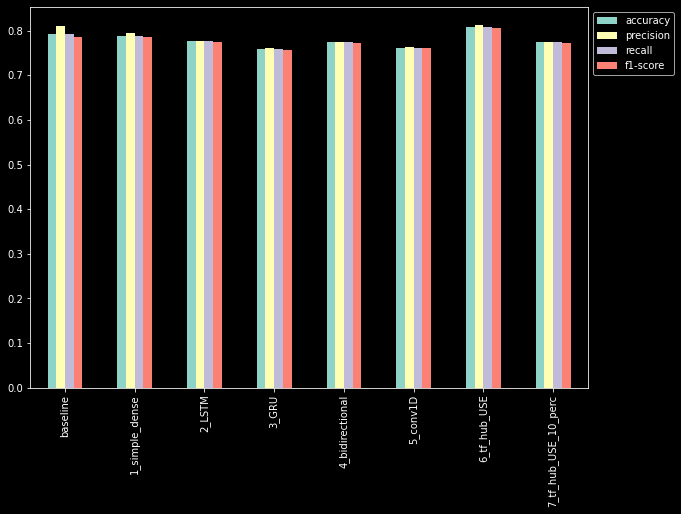

In [113]:
# Plot and compare all of the model results
all_model_results.plot(
    kind="bar", 
    figsize=(10,7)
).legend(bbox_to_anchor=(1.0, 1.0))
